## Домашнее задание №1. Базовая работа с текстами

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython import display

### Классификация токсичных комментариев
В данном задании вам предстоит построить классификатор для фильтрации токсичных сообщений в Twitter. Базового знакомтства с `Python` и методами из `sklearn` должно быть достаточно для выполнения задания. Если вы уже знакомы с `PyTorch`, можете воспользоваться и им.

__Комментарий:__ В ноутбуке присутствуют `assert`'ы для локальной проверки кода. В большинстве случаев они могут помочь найти ошибку. В некоторых (как правило, редких) случаях они могут сработать и при корректной реализации: если такое произошло, проверьте код еще раз и, по необходимости, напишите преподавателям. Если вы четко понимаете, что `assert` не срабатывает, но реализация подходит для решаемой задачи, то вы можете закомментировать его.

*Credits: This homework is inspired by [YSDA NLP course](https://github.com/yandexdataschool/nlp_course).*

In [2]:
# In colab run this cell
# ! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/homeworks_advanced/assignment1_01_Word_Vectors/features.py -nc

Файл `features.py` может быть полезен для дальнейшего выполнения задания. 

__Если вы работаете в Colab, не забудьте скачать как ноутбук, так и те файлы, в которые вы внесли изменения. При закрытии Colab эти файлы будут удалены через некоторое время__.

In [3]:
try:
    data = pd.read_csv('../../datasets/comments_small_dataset/comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

File ‘comments.tsv’ already there; not retrieving.



In [4]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [5]:
data.shape

(1000, 2)

In [6]:
data['should_ban'].mean()

0.508

In [7]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Комментарий:__ Лучше разбить данные на train и test до любых манипуляций с данными. Это позволит избежать утечки данных.

### Предобработка данных и токенизация.

В доступных данных присутствуют знаки препинания, символы верхнего и нижнего регистра, переносы строк и пр. Для упрощения структуры данных полезно будет их предобработать. Один из простейших способов: разбить текст на последовательность токенов (например, разделяя их по пробелам). Вы можете сделать это вручную, или же воспользоваться библиотекой [`nltk`](https://www.nltk.org). Эта библиотека широко используется в задачах обработки текста. Базовое знакомство с этой библиотекой пригодится вам в дальнейшем.

In [8]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [9]:
# task: preprocess each comment in train and test
vec_preprocess = np.vectorize(preprocess)

texts_train = vec_preprocess(texts_train)
texts_test = vec_preprocess(texts_test)

In [10]:
texts_train[0]

'... oh and what kind of person watches another persons mytalk page ? stalker !'

In [11]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Шаг 1: Bag of Words

Один из классических подходов к векторизации текстов. Алгоритм построения "мешка слов":

1. Построить словарь на основе обучающей выборки (только train части). Исключить наиболее редкие слова.
2. Для каждого объекта (текста) в обучающей выборке подсчитать количество вхождений каждого из слов.
3. Представить объект в виде набора счетчиков вошедших в него слов.


В качестве шаблона вы можете воспользоваться структурой класса `BoW` в файле `features.py`.

__Комментарий:__ на практике вы можете обратиться к готовым реализациям (например, к библиотеке `sklearn`). __Но в данном задании ваша задача реализовать BoW самостоятельно.__
*Для самопроверки вы можете воспользоваться существующими реализациями:*

`from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [12]:
from collections import Counter
from sklearn.base import TransformerMixin
from typing import List, Union

In [13]:
class BoW(TransformerMixin):
    """
    Bag of words tranformer class
    
    check out:
    https://scikit-learn.org/stable/modules/generated/sklearn.base.TransformerMixin.html
    to know about TransformerMixin class
    """

    def __init__(self, k: int):
        """
        :param k: number of most frequent tokens to use
        """
        self.k = k
        self.bow = None

    def fit(self, X: np.ndarray, y=None):
        """
        :param X: array of texts to be trained on
        """
        # task: find up to self.k most frequent tokens in texts_train,
        # sort them by number of occurences (highest first)
        # store most frequent tokens in self.bow
        freq = Counter()
        for text in X:
            freq.update(text.split())
        most_common_tokens = freq.most_common(self.k)
        self.bow = [token for token, _ in most_common_tokens]

        # fit method must always return self
        return self

    def _text_to_bow(self, text: str) -> np.ndarray:
        """
        convert text string to an array of token counts. Use self.bow.
        :param text: text to be transformed
        :return bow_feature: feature vector, made by bag of words
        """

        freq = Counter(text.split())
        result = [freq[word] for word in self.bow]
        
        return np.array(result, "float32")

    def transform(self, X: np.ndarray, y=None) -> np.ndarray:
        """
        :param X: array of texts to transform
        :return: array of transformed texts
        """
        assert self.bow is not None
        return np.stack([self._text_to_bow(text) for text in X])

    def get_vocabulary(self) -> Union[List[str], None]:
        return self.bow

In [14]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))


bow = BoW(k)
bow.fit(texts_train)

In [15]:
# Example template for transformation
X_train_bow = bow.transform(texts_train)
X_test_bow = bow.transform(texts_test)

In [16]:
# Small check that everything is done properly
bow_vocabulary = bow.get_vocabulary()
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Воспользуемся логистической регрессией из `sklearn` в качестве базовой модели:

In [17]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

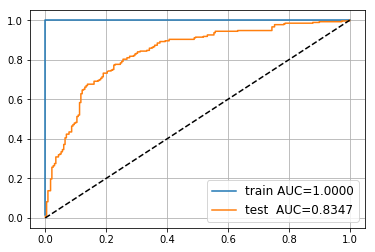

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

### Шаг 2: TF-IDF

Не все слова одинаково полезны при решении задачи классификации. Чтобы учесть этот факт, воспользуемся TF-IDF (__text frequency/inverse document frequence__):

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$

где  $x$ пример из коллекции (обучающей выборки) $D$, $N$ – общее число примеров, а $\alpha$ – гиперпараметр, отвечающий за сглаживание (обычно равен единице). $\text{Count}(word_i \in D)$ – число документов, в которые попало слово $word_i$.

Также может быть полезной отнормировать данные после подсчета TF-IDF. 

__Ваша задача:__ реализовать TF-IDF, обучить модель и оценить ее качество (аналогично BoW). Сравните полученные результаты с Bag of Words и сделайте промежуточные выводы.

В качестве шаблона вы можете воспользоваться структурой класса `TfIdf` в файле `features.py`.

*Для самопроверки вы можете воспользоваться существующими реализациями:*

`from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

Подробнее о TF-IDF можно прочитать здесь: https://triton.ml/blog/tf-idf-from-scratch

In [19]:
from collections import OrderedDict

In [20]:
class TfIdf(TransformerMixin):
    """
    Tf-Idf tranformer class
    if you have troubles implementing Tf-Idf, check out:
    https://streamsql.io/blog/tf-idf-from-scratch
    """

    def __init__(self, k: int = None, normalize: bool = False, alpha: float = 0):
        """
        :param k: number of most frequent tokens to use
        if set k equals None, than all words in train must be considered
        :param normalize: if True, you must normalize each data sample
        after computing tf-idf features
        """
        self.k = k
        self.normalize = normalize
        self.alpha = alpha

        # self.idf[term] = log(total # of documents / # of documents with term in it)
        self.idf = OrderedDict()
        

    def fit(self, X: np.ndarray, y=None):
        """
        :param X: array of texts to be trained on
        """
        freq = Counter()
        doc_with_word = {} # of documents with term in it
        for text in X:
            freq.update(text.split())
            for token in set(text.split()):
                doc_with_word.setdefault(token, 0)
                doc_with_word[token] += 1
             
        most_common_tokens = freq.most_common(self.k)
        total_of_doc = X.shape[0]
        self.idf = {token: total_of_doc / (doc_with_word[token] + self.alpha) for token, _ in most_common_tokens}
        
 
        # fit method must always return self
        return self

    def _text_to_tf_idf(self, text: str) -> np.ndarray:
        """
        convert text string to an array tf-idfs.
        *Note* don't forget to normalize, when self.normalize == True
        :param text: text to be transformed
        :return tf_idf: tf-idf features
        """

        freq = Counter(text.split())
        total_tokens_in_doc = len(text.split())
        result = [(freq[token]/total_tokens_in_doc) * (np.log(self.idf[token]) + 1) for token in self.idf]
        if self.normalize:
            return np.array(result, "float32") / (np.linalg.norm(result) + 1e-7)
        return np.array(result, "float32")

    def transform(self, X: np.ndarray, y=None) -> np.ndarray:
        """
        :param X: array of texts to transform
        :return: array of transformed texts
        """
        assert self.idf is not None
        return np.stack([self._text_to_tf_idf(text) for text in X])

In [21]:
def test_tfidf():
    from sklearn.feature_extraction.text import TfidfVectorizer
    test_text = np.array(['mom dad cat dog mom',
                         'mom', 
                         'mom', 
                         'mom cat baby'])
    tfidf = TfIdf(5, alpha=0, normalize=True)
    tfidf.fit(test_text)
    test_text_idf = tfidf.transform(test_text)
    
    sklearn_tfidf = TfidfVectorizer(max_features=5, smooth_idf=False)
    sklearn_tfidf.fit(test_text)
    test_text_sklearn_tfidf = sklearn_tfidf.transform(test_text)
    print(np.round(np.flip(test_text_idf, axis=1), 3))
    print()
    print(np.round(test_text_sklearn_tfidf.todense(), 3))

In [22]:
test_tfidf()

[[0.    0.559 0.559 0.396 0.468]
 [0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    1.   ]
 [0.772 0.    0.    0.548 0.323]]

[[0.    0.396 0.559 0.559 0.468]
 [0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    1.   ]
 [0.772 0.548 0.    0.    0.323]]


In [23]:
k = min(10000, len(set(' '.join(texts_train).split())))

In [24]:
tfidf = TfIdf(k, normalize=True)

In [25]:
tfidf.fit(texts_train)

In [26]:
X_train_tfidf = tfidf.transform(texts_train)
X_test_tfidf = tfidf.transform(texts_test)

In [27]:
tfidf_model = LogisticRegression().fit(X_train_tfidf, y_train)

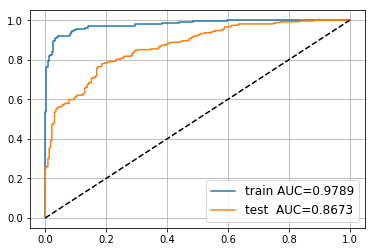

In [28]:
for name, X, y, model in [
    ('train', X_train_tfidf, y_train, tfidf_model),
    ('test ', X_test_tfidf, y_test, tfidf_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

### Шаг 3: Наивный Байесовский классификатор

Naive Bayes classifier – хороший базовый выбор для простых задач. Обучите Naive Bayes на BoW и TF-IDF признаках и сравните результаты с логистической регрессией. Какие выводы о качестве вы можете сделать?

In [139]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [30]:
bow_nb_model = MultinomialNB().fit(X_train_bow, y_train)
tfidf_nb_model = MultinomialNB().fit(X_train_tfidf, y_train)

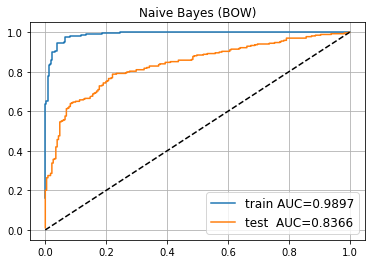

In [31]:
for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_nb_model),
    ('test ', X_test_bow, y_test, bow_nb_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.title('Naive Bayes (BOW)')
plt.grid()

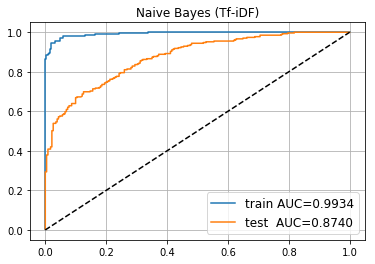

In [32]:
for name, X, y, model in [
    ('train', X_train_tfidf, y_train, tfidf_nb_model),
    ('test ', X_test_tfidf, y_test, tfidf_nb_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.title('Naive Bayes (Tf-iDF)')
plt.grid()

__Ваши промежуточные выводы:__

Без настройки параметров алгоритмов и использования их "из коробки" лучшее качество показывает tf-idf ембединги и модель наивного Байеса

### Шаг 4: Использование предобученных эмбеддингов

Воспользуйтесь предобученными эмбеддингами из `gensim` (или `fasttext`) и преобразуйте тексты в векторный вид. 
Для получения векторного представления для всего текста можно просто усреднить все вектора. По аналогии с Bag of Words такой подход можно было бы назвать "Bag of Embeddings".

Общая процедура построения выглядит следующим образом:
1. Поставить каждому слову в соответствие вектор из `gensim` или `fasttext`. Если слово отсутствует в словаре, его можно пропустить.
2. Для каждого текста усреднить вектора слов, вошедших в этот текст. Если все слова отсутствуют в словаре, то вы можете исключить данный пример из рассмотрения.
3. На основе полученных признаков решите задачу классификации с помощью логистической регрессии, наивного Байесовского классификатора и какой-либо третьей модели (на ваш выбор).

Сравните полученные результаты с предыдущими подходами. 


Для простоты можете использовать усредненный вектор для всех слов. Сравните результаты с предыдущими подходами, сделайте выводы.

In [33]:
import fasttext.util

In [34]:
# fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('cc.en.300.bin')

In [127]:
def fasttext_transform(texts, normalize=True):
    result = None
    for text in texts:
        text_embedding = np.array([ft.get_word_vector(word) for word in text.split()]).mean(axis=0)
        if normalize:
            text_embedding = text_embedding / (np.linalg.norm(text_embedding) + 1e-8)
        if result is None:
            result = text_embedding
        else:
            result = np.vstack((result, text_embedding))
    return result

In [128]:
X_train_ft = fasttext_transform(texts_train)
X_test_ft = fasttext_transform(texts_test)

In [130]:
ft_model = LogisticRegression().fit(X_train_ft, y_train)

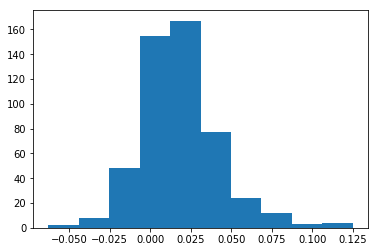

In [149]:
plt.hist(X_train_ft[:, 0]);

In [143]:
ft_nb_model = GaussianNB().fit(X_train_ft, y_train)

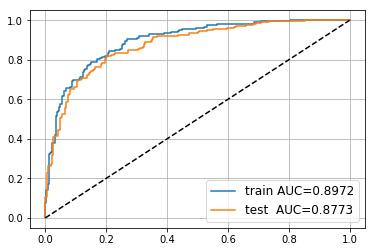

In [144]:
for name, X, y, model in [
    ('train', X_train_ft, y_train, ft_model),
    ('test ', X_test_ft, y_test, ft_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

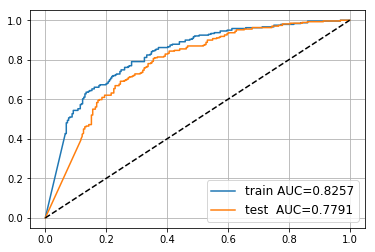

In [145]:
for name, X, y, model in [
    ('train', X_train_ft, y_train, ft_nb_model),
    ('test ', X_test_ft, y_test, ft_nb_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Ваши выводы:


Пожалуйста, оставьте обратную связь о задании [по ссылке](http://rebrand.ly/mfnlp2020q4_feedback_hw01). Она (при желании) анонимна ;)